In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
import time
from math import pi

Following the order of [Spatiotemporal Tiling of the Kuramoto-Sivashinsky Equation](#thesis), the next process that was developed after the ability to find periodic orbits was to clip out smaller domains and use them to find "fundamental periodic orbits". These are the smallest periodic orbits which serve as building blocks for all other solutions.


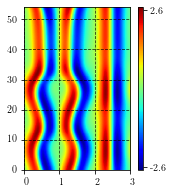

In [2]:
orbit_ = read_h5('OrbitKS_L26p744_T54p129.h5', directory='../data/examples/')
orbit_.plot()

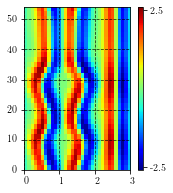

In [3]:
kse_integrate(orbit_)

orbit_.rotate(0.1, axis=1).rotate(3, axis=0).plot(padding=False)

res_list = []
for tmax in np.arange(10, 21):
    clipped_orbit = clip(orbit_.rotate(0.1, axis=1).rotate(10, axis=0), ((0., tmax), (None, None)))
    res_list.append(clipped_orbit.residual())

best_window_max = np.arange(10, 21)[np.argmin(res_list)]
clipped_orbit = clip(orbit_.rotate(0.1, axis=1).rotate(5, axis=0), ((0., best_window_max), (None, None)))

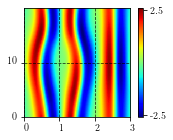

In [4]:
clipped_orbit.plot()

In [5]:
cresult = []
orbittols = [10**-i for i in range(8)]
for otol in orbittols:
    converge_result = converge(clipped_orbit, orbit_tol=otol, verbose=True)
    cresult.append(converge_result)

Starting gradient descent. Initial residual=0.018326097254269206, target=0.01, max_iter=6144
Starting lstsq. Initial residual=0.009791495409318366, target=0.01

Converged. exiting with residual 0.009791495409318366
Starting gradient descent. Initial residual=0.018326097254269206, target=0.001, max_iter=6144
############ Residual=0.0012160903403793837 after 1536 gradient descent iterations
############# Residual=0.0010263882428924265 after 3072 gradient descent iterations
###Starting lstsq. Initial residual=0.0009999886758319527, target=0.001

Converged. exiting with residual 0.0009999886758319527
Starting gradient descent. Initial residual=0.018326097254269206, target=0.0001, max_iter=6144
############ Residual=0.0012160903403793837 after 1536 gradient descent iterations
############# Residual=0.0010263882428924265 after 3072 gradient descent iterations
############ Residual=0.000951490068053024 after 4608 gradient descent iterations
############# Residual=0.0008985121806372466 after 6

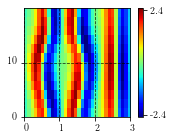

Starting gradient descent. Initial residual=0.10744369637266475, target=3.6000000000000005e-07, max_iter=5760
Starting lstsq. Initial residual=3.403966602501304e-07, target=3.6000000000000005e-07

Converged. exiting with residual 3.403966602501304e-07
Saving data to ../data/continuation/clipping_minimal\OrbitKS_L26p440_T20p377.h5
Saving figure to ../data/continuation/clipping_minimal\OrbitKS_L26p440_T20p377.png
Starting gradient descent. Initial residual=0.14884944048911292, target=3.3600000000000004e-07, max_iter=5376
###Gradient descent has stalled; exiting. Decrease ftol to avoid this behavior.
Starting lstsq. Initial residual=3.5516121607481586e-07, target=3.3600000000000004e-07
56
Converged. exiting with residual 3.3562902017059e-07
Saving data to ../data/continuation/clipping_minimal\OrbitKS_L26p444_T20p399.h5
Saving figure to ../data/continuation/clipping_minimal\OrbitKS_L26p444_T20p399.png
Starting gradient descent. Initial residual=0.5290753075051311, target=3.1200000000000004

In [6]:
cresult[0].orbit.plot(padding=False)

small_orbit = discretization_continuation(cresult[-1].orbit, (12, 16), verbose=True, save=True, directory='../data/continuation/clipping_minimal')

In [7]:
smallest_clipping_orbit = small_orbit.orbit

In [8]:
small_orbit_result = discretization_continuation(smallest_clipping_orbit, (12, 14), verbose=True, save=True, directory='../data/continuation/clipping_minimal')

Starting gradient descent. Initial residual=20.564070735424522, target=1.6800000000000002e-07, max_iter=2688
############ Residual=0.4971240382538649 after 672 gradient descent iterations
############# Residual=0.3448623892494875 after 1344 gradient descent iterations
############# Residual=0.23271111418911603 after 2016 gradient descent iterations
############ Residual=0.18430768522309357 after 2688 gradient descent iterations
Starting lstsq. Initial residual=0.18430768522309357, target=1.6800000000000002e-07
4434444653334464433220132 Residual=0.01851941291305317 after 25 lstsq iterations
344322220000
Converged to an equilibrium exiting with residual 0.49215257333290713
Saving data to ../data/continuation/clipping_minimal\EquilibriumOrbitKS_L25p06.h5
Saving figure to ../data/continuation/clipping_minimal\EquilibriumOrbitKS_L25p06_fdomain.png


In [9]:
small_orbit_result

 exit_code: 3
    n_iter: (2688, 37)
     orbit: EquilibriumOrbitKS({"state_type": "modes", "L": "2.51e+01", "N": "1", "M": "14"})

In [10]:
small_orbit.orbit.dt().norm()

1.612547496628253

In [11]:
smallest_clipping_orbit

OrbitKS({"state_type": "modes", "T": "2.06e+01", "L": "2.58e+01", "N": "12", "M": "16"})

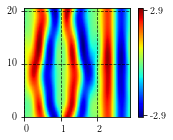

In [12]:
smallest_clipping_orbit.plot()

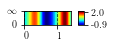

In [13]:
small_orbit_result.orbit.plot()

In [14]:
small_orbit_result.orbit

EquilibriumOrbitKS({"state_type": "modes", "L": "2.51e+01", "N": "1", "M": "14"})

0.018326097254269206
Integration progress [##########################]

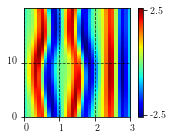

0.018326097254269206
Integration progress [##########################]

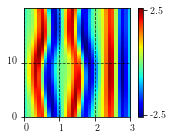

0.009791495409318366
Integration progress [#########################]

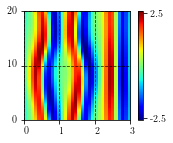

0.0009999886758319527
Integration progress [##########################]

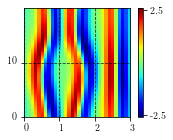

6.141427036772604e-05
Integration progress [##########################]

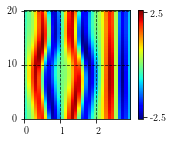

9.109478702422688e-06
Integration progress [##########################]

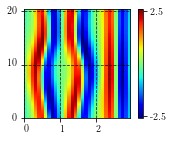

1.411472683786121e-13
Integration progress [##########################]

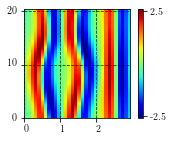

1.411472683786121e-13
Integration progress [##########################]

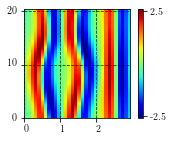

In [15]:
i_orbits = []
for c in cresult:
    print(c.orbit.residual())
    int_orbit = kse_integrate(c.orbit, verbose=True)
    int_orbit.plot(padding=False)
    i_orbits.append(int_orbit)

In [16]:
cresult[0].orbit.field_shape

(12, 32)

In [17]:
for o in i_orbits:
    rediscretize(o, new_shape=())

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2001 and the array at index 1 has size 2000

In [ ]:
if None:

In [19]:
if None:
    print('teuhri')

In [ ]:
cresult[5].orbit.residual(), cresult[-1].orbit.residual()

In [ ]:
(rediscretize(cresult[5].orbit, new_shape=(512,512)) - rediscretize(cresult[-1].orbit, new_shape=(512,512))).convert(to='field').state.max()

In [ ]:
(rediscretize(cresult[5].orbit, new_shape=(512,512)) - rediscretize(cresult[-1].orbit, new_shape=(512,512))).plot(padding=False)

In [ ]:
integrate_kse(cresult[0].orbit)

In [ ]:
for corbit in 

In [ ]:
clipping_result = converge(clipped_orbit, method='gradient_descent', precision='machine', preconditioning=True, verbose=True)
clipping_result = converge(clipping_result.orbit, method='gradient_descent', precision='machine', preconditioning=False, verbose=True)


In [ ]:
clipping = clipping_result.orbit

In [ ]:
clipping.plot()

In [ ]:
t0 = time.time()
converge_result = converge(clipped_orbit, method='gradient_descent', precision='machine', verbose=True)
t2 = time.time()
print('per iter', converge_result.n_iter / (t2-t0))


For this demonstration, I will use the very first orbit and clipping method I ever applied, which was an iterative procedure to find (converge) a sequence of progressively smaller orbits.

In [ ]:
orbit_.plot()

The structure defined approximately on $t \in [0, 15], x \in [0, 2]$ looks to repeat twice. Therefore this is the target of the clipping. Again, I want to stress that this iterative manner of clipping is now known to be **unnecessary**, but it was how this calculation was originally performed. Orbithunter's utility again shines here via the function 'clip'.

In [ ]:
?clip

In [ ]:
clip(orbit_, ((0, 15),(0, 2)))

In [ ]:
orbit1 = read_h5('OrbitKS_L31p245_T46p754.h5')
orbit2 = read_h5('OrbitKS_L26p931_T41p266.h5')
orbit3 = read_h5('OrbitKS_L26p427_T80p246.h5')
orbit4 = read_h5('OrbitKS_L27p038_T23p329.h5')

In [ ]:
orbit1 = rediscretize(orbit1, new_shape=(64, 64))

orbit2 = rediscretize(orbit2, new_shape=(64, 64))

orbit3 = rediscretize(orbit3, new_shape=(64, 64))

orbit4 = rediscretize(orbit4, new_shape=(64, 64))

In [ ]:
from orbithunter.gluing import tile_dictionary_ks

In [ ]:
OrbitKS.dimensions()

In [ ]:
tile_shape = (64, 64)
tiled_orbit = tile(np.array([[0,1],[1,0]]), tile_shape, tile_dictionary_ks(padded=True), OrbitKS)

In [ ]:
iterable_of_orbits = [OrbitKS(T=0.5, L=22), orbit2, orbit3, orbit4]
axis = 0 
# need to iterate over all orbits, find the total dimension and # of points, then create the new_shape tuples.
total_dimension = 0
total_discretization = 0
for o in iterable_of_orbits:
    total_dimension += o.parameters[o.dimensions()[axis]]
    total_discretization += o.parameters['field_shape'][axis]

# Replace the # of points along axis with the rescaled values based upon the total extent of the axis dimension.

new_shapes = [tuple(int(2 * ((((total_discretization * o.parameters[o.dimensions()[axis]]) / total_dimension)+1) // 2))
              if i == axis else o.parameters['field_shape'][i] for i in range(len(o.shape)))
              for o in iterable_of_orbits]
new_shapes

In [ ]:
iterable_of_reshaped_orbits = [rediscretize(o, new_shape=shp)
                               for o, shp in zip(iterable_of_orbits, new_shapes)]

In [ ]:
total_discretization = 202
total_dimension=179


In [ ]:
np.mod([max([2, int(2 * ((((total_discretization * test_dimension) / total_dimension) + 1) // 2))]) for test_dimension in np.arange(1, 200, 0.01)], 2).sum()


In [ ]:
 int(2 * ((((total_discretization * test_dimension) / total_dimension) + 1) // 2))

In [ ]:
converge(tiled_orbit, verbose=True)

In [ ]:
pcc, persistence = orbit_persistence(orbit1)

In [ ]:
gudhi_plot(persistence)